In [ ]:
# !pip install -q yacs unicodedata2 nltk albumentations transformers==4.31.0 sentencepiece evaluate accelerate torchinfo scikit-image matplotlib 

In [ ]:
# !gdown 1TztHmmwN8R6MGEABPnxgaBErZ4vDOjdJ
# !unzip -q 'vivqa-dataset.zip'
# !rm /content/vivqa-dataset.zip

In [ ]:
# # Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [41]:
import os
import gc
import string
import math
import numpy as np

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations import Compose
from PIL import Image
from skimage import io, transform

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import string
from nltk.corpus import wordnet
from typing import List, Optional, Union, Dict, Tuple

import warnings
warnings.filterwarnings('ignore')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Config

In [42]:
if os.path.exists('/content/drive'):
    BASE_DIR = '/content/drive/MyDrive'
else:
    BASE_DIR = ''

IMAGES_DIR = "/home/tgng/coding/modeltuner/data/preprocessed_images"
TRAIN_PATH = "/home/tgng/coding/modeltuner/data/text/train_60k_data_balanced.csv"
TEST_PATH = "/home/tgng/coding/modeltuner/data/text/val_60k_data_balanced.csv"

In [43]:
from yacs.config import CfgNode
import yaml

config_file = "/home/tgng/coding/modeltuner/bartpho_beit_generate.yaml"

with open(config_file, "r") as stream:
    try:
        CONFIG =  CfgNode(init_dict=yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

print(CONFIG.MODEL.NAME)
print(CONFIG.MODEL.VISION_EMBEDDING.PRETRAINED_NAME)
print(CONFIG.MODEL.TEXT_EMBEDDING.PRETRAINED_NAME)

bartpho_beit_generate
microsoft/beit-base-patch16-224-pt22k-ft22k
vinai/bartpho-word-base


# Prepare Dataset

In [44]:
# Load train.csv
train_df = pd.read_csv(TRAIN_PATH)
if train_df.shape[1] > 4:
    train_df = train_df.iloc[: , 1:] # Drop first column (index)

# Load test.csv
test_df = pd.read_csv(TEST_PATH)
if test_df.shape[1] > 4:
    test_df = test_df.iloc[: , 1:] # Drop first column (index)

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (33370, 4)
Test shape: (3707, 4)


In [45]:
import ast
test_df['answers'] = test_df['answers'].apply(ast.literal_eval)
train_df['answers'] = train_df['answers'].apply(ast.literal_eval)

In [ ]:
# test_df.drop(columns=['etp_txt_grammar_Reason_for_question',
#        'etp_txt_grammar_Score_for_answers',
#        'etp_txt_grammar_Reason_for_answers',
#        'etp_txt_unambiguity_Score_for_question',
#        'etp_txt_unambiguity_Reason_for_question',
#        'etp_txt_unambiguity_Score_for_answers',
#        'etp_txt_unambiguity_Reason_for_answers',
#        'etp_txt_qa_structure_Score_for_question',
#        'etp_txt_qa_structure_Reason_for_question',
#        'etp_txt_qa_structure_Score_for_answers',
#        'etp_txt_qa_structure_Reason_for_answers',
#        'etp_syntactic_complexity_Score_for_question',
#        'etp_syntactic_complexity_Reason_for_question',
#        'etp_syntactic_complexity_Score_for_answers',
#        'etp_syntactic_complexity_Reason_for_answers',
#        'etp_language_naturalness_Score_for_question',
#        'etp_language_naturalness_Reason_for_question',
#        'etp_language_naturalness_Score_for_answers',
#        'etp_language_naturalness_Reason_for_answers', 'eip_img_clarity_Score',
#        'eip_img_clarity_Reason', 'eip_img_occlusion_Score',
#        'eip_img_occlusion_Reason', 'eip_img_diff_ability_Score',
#        'eip_img_diff_ability_Reason', 'eip_img_object_density_Score',
#        'eip_img_interaction_level_Score', 'eip_img_interaction_level_Reason',
#        'eip_img_scene_clutter_Score', 'idp_Img_scene_type',
#        'idp_Img_main_object', 'idp_Image_mainobj_descrip',
#        'idp_Cultural_context', 'idp_Demographic_signals',
#        'idp_Scene_typicality_score', 'vqac_question_to_image_response',
#        'vqac_question_to_image_reason', 'vqac_answer_to_image_response',
#        'vqac_answer_to_image_overall_response', 'vqac_answer_to_image_reason',
#        'vqac_question_to_answer_response',
#        'vqac_question_to_answer_overall_response',
#        'vqac_question_to_answer_reason', 'vqac_guess_the_answer_response',
#        'vqac_guess_the_answer_reason', 'vqac_reason_depth_response',
#        'vqac_reason_depth_reason', 'etp_txt_grammar_Score_answers_median',
#        'etp_txt_unambiguity_Score_answers_median',
#        'etp_txt_qa_structure_Score_answers_median',
#        'etp_syntactic_complexity_Score_answers_median',
#        'etp_language_naturalness_Score_answers_median',
#        'etp_txt_grammar_Score_for_question_Label',
#        'etp_txt_unambiguity_Score_for_question_Label',
#        'etp_txt_qa_structure_Score_for_question_Label',
#        'etp_syntactic_complexity_Score_for_question_Label',
#        'etp_language_naturalness_Score_for_question_Label',
#        'eip_img_clarity_Score_Label', 'eip_img_occlusion_Score_Label',
#        'eip_img_diff_ability_Score_Label',
#        'eip_img_object_density_Score_Label',
#        'eip_img_interaction_level_Score_Label',
#        'eip_img_scene_clutter_Score_Label', 'idp_Scene_typicality_score_Label',
#        'vqac_reason_depth_response_Label',
#        'etp_txt_grammar_Score_answers_median_Label',
#        'etp_txt_unambiguity_Score_answers_median_Label',
#        'etp_txt_qa_structure_Score_answers_median_Label',
#        'etp_syntactic_complexity_Score_answers_median_Label',
#        'etp_language_naturalness_Score_answers_median_Label'], inplace=True)
# train_df.drop(columns=['etp_txt_grammar_Reason_for_question',
#        'etp_txt_grammar_Score_for_answers',
#        'etp_txt_grammar_Reason_for_answers',
#        'etp_txt_unambiguity_Score_for_question',
#        'etp_txt_unambiguity_Reason_for_question',
#        'etp_txt_unambiguity_Score_for_answers',
#        'etp_txt_unambiguity_Reason_for_answers',
#        'etp_txt_qa_structure_Score_for_question',
#        'etp_txt_qa_structure_Reason_for_question',
#        'etp_txt_qa_structure_Score_for_answers',
#        'etp_txt_qa_structure_Reason_for_answers',
#        'etp_syntactic_complexity_Score_for_question',
#        'etp_syntactic_complexity_Reason_for_question',
#        'etp_syntactic_complexity_Score_for_answers',
#        'etp_syntactic_complexity_Reason_for_answers',
#        'etp_language_naturalness_Score_for_question',
#        'etp_language_naturalness_Reason_for_question',
#        'etp_language_naturalness_Score_for_answers',
#        'etp_language_naturalness_Reason_for_answers', 'eip_img_clarity_Score',
#        'eip_img_clarity_Reason', 'eip_img_occlusion_Score',
#        'eip_img_occlusion_Reason', 'eip_img_diff_ability_Score',
#        'eip_img_diff_ability_Reason', 'eip_img_object_density_Score',
#        'eip_img_interaction_level_Score', 'eip_img_interaction_level_Reason',
#        'eip_img_scene_clutter_Score', 'idp_Img_scene_type',
#        'idp_Img_main_object', 'idp_Image_mainobj_descrip',
#        'idp_Cultural_context', 'idp_Demographic_signals',
#        'idp_Scene_typicality_score', 'vqac_question_to_image_response',
#        'vqac_question_to_image_reason', 'vqac_answer_to_image_response',
#        'vqac_answer_to_image_overall_response', 'vqac_answer_to_image_reason',
#        'vqac_question_to_answer_response',
#        'vqac_question_to_answer_overall_response',
#        'vqac_question_to_answer_reason', 'vqac_guess_the_answer_response',
#        'vqac_guess_the_answer_reason', 'vqac_reason_depth_response',
#        'vqac_reason_depth_reason', 'etp_txt_grammar_Score_answers_median',
#        'etp_txt_unambiguity_Score_answers_median',
#        'etp_txt_qa_structure_Score_answers_median',
#        'etp_syntactic_complexity_Score_answers_median',
#        'etp_language_naturalness_Score_answers_median',
#        'etp_txt_grammar_Score_for_question_Label',
#        'etp_txt_unambiguity_Score_for_question_Label',
#        'etp_txt_qa_structure_Score_for_question_Label',
#        'etp_syntactic_complexity_Score_for_question_Label',
#        'etp_language_naturalness_Score_for_question_Label',
#        'eip_img_clarity_Score_Label', 'eip_img_occlusion_Score_Label',
#        'eip_img_diff_ability_Score_Label',
#        'eip_img_object_density_Score_Label',
#        'eip_img_interaction_level_Score_Label',
#        'eip_img_scene_clutter_Score_Label', 'idp_Scene_typicality_score_Label',
#        'vqac_reason_depth_response_Label',
#        'etp_txt_grammar_Score_answers_median_Label',
#        'etp_txt_unambiguity_Score_answers_median_Label',
#        'etp_txt_qa_structure_Score_answers_median_Label',
#        'etp_syntactic_complexity_Score_answers_median_Label',
#        'etp_language_naturalness_Score_answers_median_Label'], inplace=True)

## Remove duplicate

In [47]:
# # Remove duplicate train_df
# train_df.drop_duplicates(keep=False, inplace=True)
# train_df.to_csv(TRAIN_PATH, index=False)
# print(f'Train shape: {train_df.shape}')

# # Remove duplicate test_df
# test_df.drop_duplicates(keep=False, inplace=True)
# test_df.to_csv(TEST_PATH, index=False)
# print(f'Test shape: {test_df.shape}')

In [48]:
test_df.head()

,question,answers,image_url,image_name
0,Các ván lướt sóng được xếp dọc theo cái gì?,"[Dọc theo hàng rào, Dọc theo lan can, Dọc theo...",http://images.cocodataset.org/train2017/000000...,000000281508.jpg
1,Mối quan hệ giữa mô hình tàu hoả và khu vườn l...,"[Tàu hoả chạy quanh đường ray trong vườn, Đoàn...",http://images.cocodataset.org/train2017/000000...,000000458420.jpg
2,Màu sắc của con mèo là gì?,"[Đen và nâu, Nâu đen, Màu đen, Chủ yếu là nâu,...",http://images.cocodataset.org/train2017/000000...,000000552395.jpg
3,Đồng hồ treo bên ngoài tòa nhà có màu gì?,"[Màu xanh lá, Màu ngọc lam, Màu xanh lá cây, X...",http://images.cocodataset.org/train2017/000000...,000000170024.jpg
4,Ghế dài này thường được đặt ở đâu?,"[Ở ngoài trời, Dọc vỉa hè, Gần đường phố, Tron...",http://images.cocodataset.org/train2017/000000...,000000261670.jpg


## Split train & valid dataset

In [49]:
from sklearn.model_selection import train_test_split

train_X, valid_X = train_test_split(train_df, test_size=0.2, random_state=42)
train_df = train_X.reset_index(drop=True)
valid_df = valid_X.reset_index(drop=True)

print(f'Train shape: {train_df.shape}')
print(f'Valid shape: {valid_df.shape}')

Train shape: (26696, 4)
Valid shape: (6674, 4)


## Build dataset class

In [54]:
# Build dataset class
class ViVQA_Dataset(torch.utils.data.Dataset):
    """
    Dataset class for the ViVQA dataset.
    """
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        question = self.df.loc[idx, 'question']
        answers = self.df.loc[idx, 'answers']  # list of 5 answers
        answer = np.random.choice(answers)  # randomly select one answer
        image_name = self.df.loc[idx, 'image_name']
        img_file = os.path.join(self.img_dir, image_name)
        return {'image': img_file, 'question': question, 'answer': answer}


In [55]:
train_dataset = ViVQA_Dataset(train_df, IMAGES_DIR)
valid_dataset = ViVQA_Dataset(valid_df, IMAGES_DIR)

test_df.reset_index(drop=True, inplace=True)
test_dataset = ViVQA_Dataset(test_df, IMAGES_DIR)

print(f'[INFO] Train size: {len(train_dataset)}')
print(f'[INFO] Valid size: {len(valid_dataset)}')
print(f'[INFO] Test size:  {len(test_dataset)}')

[INFO] Train size: 26696
[INFO] Valid size: 6674
[INFO] Test size:  3707


In [56]:
# Visualize 'no_' images in dataset
def plot_img(dataset_show, no_):
    images, questions, answers = [],[],[]
    random_idx = np.random.choice(len(dataset_show),no_)
    for i in random_idx:
        data = dataset_show.__getitem__(i)
        image = data['image']
        question = data['question']
        answer = data['answer']
        images.append(image)
        questions.append(question)
        answers.append(answer)
    plt.figure(figsize=(12,8))
    for idx in range(0,no_):
        img_path = images[idx]
        image = Image.open(img_path).convert('RGB')
        plt.subplot(2,no_,idx+1)
        plt.title('Q: ' + questions[idx] + '\n A: '+ answers[idx])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

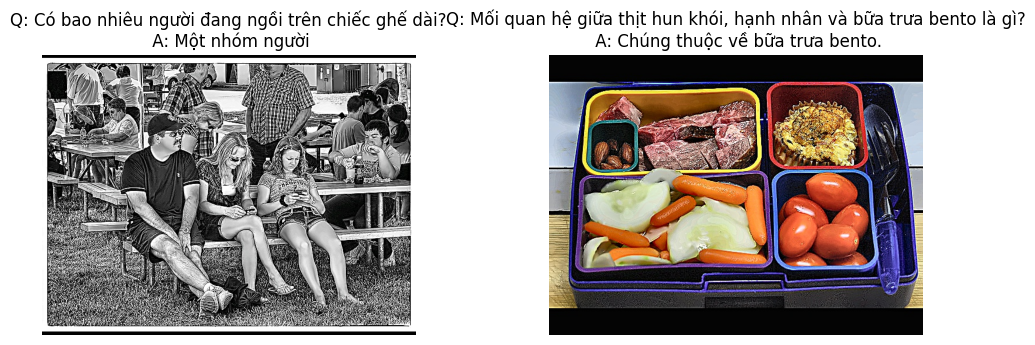

In [57]:
# Visualize 2 images in dataset
plot_img(train_dataset, 2)

# Metrics

## CIDEr

In [58]:
import copy
from collections import defaultdict
import math

def precook(s, n=4):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = str(s).split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def __init__(self, refs, test=None, n=4, sigma=6.0, doc_frequency=None, ref_len=None):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.doc_frequency = defaultdict(float)
        self.ref_len = None

        for k in range(len(refs)):
            self.crefs.append(cook_refs(refs[k]))
            if test is not None:
                self.ctest.append(cook_test(test[k][0]))  ## N.B.: -1
            else:
                self.ctest.append(None)  # lens of crefs and ctest have to match

        if doc_frequency is None and ref_len is None:
            # compute idf
            self.compute_doc_freq()
            # compute log reference length
            self.ref_len = np.log(float(len(self.crefs)))
        else:
            self.doc_frequency = doc_frequency
            self.ref_len = ref_len

    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.doc_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.doc_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    # vrama91 : added clipping
                    val[n] += min(vec_hyp[n][ngram], vec_ref[n][ngram]) * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
                # vrama91: added a length based gaussian penalty
                val[n] *= np.e**(-(delta**2)/(2*self.sigma**2))
            return val

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self):
        # compute cider score
        score = self.compute_cider()
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)

## Extract match

In [59]:
class Exact_Match:
    def compute_score(self, y_true, y_pred):
        if y_true==y_pred:
            return 1
        else:
            return 0

## F1 Score

In [60]:
class F1:
  def Precision(self,y_true,y_pred):
    if y_pred is None:
       return 0
    common = set(y_true) & set(y_pred)
    return len(common) / len(set(y_pred))

  def Recall(self,y_true,y_pred):
    common = set(y_true) & set(y_pred)
    return len(common) / len(set(y_true))

  def compute_score(self,y_true,y_pred):
    if len(y_pred) == 0 or len(y_true) == 0:
        return int(y_pred == y_true)

    precision = self.Precision(y_true, y_pred)
    recall = self.Recall(y_true, y_pred)

    if precision == 0 or recall == 0:
        return 0
    f1 = 2*precision*recall / (precision+recall)
    return f1

## Wup

In [61]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

class Wup:
    def get_semantic_field(self,a):
        weight = 1.0
        semantic_field = wordnet.synsets(str(a), pos=wordnet.NOUN)
        return (semantic_field,weight)

    def get_stem_word(self,a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)
    def compute_score(self, a: str, b: str, similarity_threshold: float = 0.9):
        """
        Returns Wu-Palmer similarity score.
        More specifically, it computes:
            max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
            where interp is a 'interpretation field'
        """
        global_weight=1.0

        (a,global_weight_a)=self.get_stem_word(a)
        (b,global_weight_b)=self.get_stem_word(b)
        global_weight = min(global_weight_a,global_weight_b)

        if a==b:
            # they are the same
            return 1.0*global_weight

        if a==[] or b==[]:
            return 0

        interp_a,weight_a = self.get_semantic_field(a)
        interp_b,weight_b = self.get_semantic_field(b)

        if interp_a == [] or interp_b == []:
            return 0

        # we take the most optimistic interpretation
        global_max=0.0
        for x in interp_a:
            for y in interp_b:
                local_score=x.wup_similarity(y)
                if local_score > global_max:
                    global_max=local_score

        # we need to use the semantic fields and therefore we downweight
        # unless the score is high which indicates both are synonyms
        if global_max < similarity_threshold:
            interp_weight = 0.1
        else:
            interp_weight = 1.0

        final_score=global_max*weight_a*weight_b*interp_weight*global_weight
        return final_score

[nltk_data] Downloading package wordnet to /home/tgng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Score Calculator

In [62]:
import re
import unicodedata

def normalize_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower().strip()
    return text

def preprocess_sentence(sentence: str, tokenizer=None):
    sentence = sentence.lower()
    sentence = unicodedata.normalize('NFC', sentence)
    sentence = re.sub(r"[“”]", "\"", sentence)
    sentence = re.sub(r"!", " ! ", sentence)
    sentence = re.sub(r"\?", " ? ", sentence)
    sentence = re.sub(r":", " : ", sentence)
    sentence = re.sub(r";", " ; ", sentence)
    sentence = re.sub(r",", " , ", sentence)
    sentence = re.sub(r"\"", " \" ", sentence)
    sentence = re.sub(r"'", " ' ", sentence)
    sentence = re.sub(r"\(", " ( ", sentence)
    sentence = re.sub(r"\[", " [ ", sentence)
    sentence = re.sub(r"\)", " ) ", sentence)
    sentence = re.sub(r"\]", " ] ", sentence)
    sentence = re.sub(r"/", " / ", sentence)
    sentence = re.sub(r"\.", " . ", sentence)
    sentence = re.sub(r"-", " - ", sentence)
    sentence = re.sub(r"\$", " $ ", sentence)
    sentence = re.sub(r"\&", " & ", sentence)
    sentence = re.sub(r"\*", " * ", sentence)
    # tokenize the sentence
    if tokenizer is None:
        tokenizer = lambda s: s
    sentence = tokenizer(sentence)
    sentence = " ".join(sentence.strip().split()) # remove duplicated spaces
    tokens = sentence.strip().split()

    return tokens

class ScoreCalculator:
    def __init__(self):
        self.f1_caculate=F1()
        self.em_caculate=Exact_Match()
        self.Wup_caculate=Wup()
    #F1 score character level
    def f1_char(self,labels: List[str], preds: List[str]) -> float:
        scores=[]
        for i in range(len(labels)):
            scores.append(self.f1_caculate.compute_score(str(preprocess_sentence(normalize_text(labels[i]))).split(),str(preprocess_sentence(normalize_text(preds[i]))).split()))
        return np.mean(scores)

    #F1 score token level
    def f1_token(self,labels: List[str], preds: List[str]) -> float:
        scores=[]
        for i in range(len(labels)):
            scores.append(self.f1_caculate.compute_score(str(preprocess_sentence(normalize_text(labels[i]))).split(),str(preprocess_sentence(normalize_text(preds[i]))).split()))
        return np.mean(scores)
    #Excat match score
    def em(self,labels: List[str], preds: List[str]) -> float:
        scores=[]
        for i in range(len(labels)):
            scores.append(self.em_caculate.compute_score(str(preprocess_sentence(normalize_text(labels[i]))).split(),str(preprocess_sentence(normalize_text(preds[i]))).split()))
        return np.mean(scores)
    #Wup score
    def wup(self,labels: List[str], preds: List[str]) -> float:
        scores=[]
        for i in range(len(labels)):
            scores.append(self.Wup_caculate.compute_score(str(preprocess_sentence(normalize_text(labels[i]))).split(),str(preprocess_sentence(normalize_text(preds[i]))).split()))
        return np.mean(scores)
    #Cider score
    def cider_score(self,labels: List[str], preds: List[str]) -> float:
        labels=[[preprocess_sentence(normalize_text(label))] for label in labels]
        preds=[[preprocess_sentence(normalize_text(pred))] for pred in preds ]
        cider_caculate= CiderScorer(labels, test=preds, n=4, sigma=6.)
        scores,_=cider_caculate.compute_score()
        return scores

# Model

In [63]:
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple
import copy
import math
import random

from transformers import MBartPreTrainedModel, MBartConfig, AutoModel, AutoConfig, AutoTokenizer, BeitImageProcessor
from transformers.models.mbart.modeling_mbart import (
    MBartLearnedPositionalEmbedding,
    MBartEncoderLayer, MBartEncoder, MBartDecoder,
    MBartModel, MBartForConditionalGeneration,
    MBartConfig,
    ACT2FN,
    shift_tokens_right, _expand_mask
)
from transformers.modeling_outputs  import (
    ModelOutput,
    BaseModelOutput,
    BaseModelOutputWithPastAndCrossAttentions,
    Seq2SeqLMOutput,
    Seq2SeqModelOutput,
)
from torch.nn import CrossEntropyLoss
from torch import optim
from transformers import AutoModel
from torch.utils.checkpoint import checkpoint
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map

In [64]:
class JointEncoder(MBartEncoder):
    """
    MBartEncoder + visual embedding
    """
    def __init__(self, config, embed_tokens=None):
        super().__init__(config, embed_tokens)
        self.config = config
        self.visual_embedding = AutoModel.from_pretrained(config.vision_model)
        for param in self.visual_embedding.parameters():
            param.requires_grad = False
        self.project_vision=nn.Linear(config.d_vision,config.d_model)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        pixel_values=None,
        vis_attention_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids) * self.embed_scale

        embed_pos = self.embed_positions(input_ids)
        inputs_embeds = inputs_embeds + embed_pos

        B, L = inputs_embeds.size()[:-1]

        img_feat = self.visual_embedding(pixel_values).last_hidden_state
        img_feat = self.project_vision(img_feat)
        V_L = img_feat.size(1)

        if self.config.share_vis_lang_layer_norm:
            inputs_embeds = torch.cat([inputs_embeds, img_feat], dim=1)
            inputs_embeds = self.layernorm_embedding(inputs_embeds)
        else:
            inputs_embeds = self.layernorm_embedding(inputs_embeds)
            inputs_embeds = torch.cat([inputs_embeds, img_feat], dim=1)

        hidden_states = F.dropout(inputs_embeds, p=self.dropout, training=self.training)

        if attention_mask is None:
            attention_mask = input_ids.ne(self.config.pad_token_id).to(dtype=inputs_embeds.dtype, device=inputs_embeds.device)

        vis_attention_mask = torch.ones(B, V_L, dtype=inputs_embeds.dtype, device=inputs_embeds.device)

        attention_mask = torch.cat([attention_mask, vis_attention_mask], dim=1)

        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, inputs_embeds.dtype)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        for encoder_layer in self.layers:
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                if getattr(self.config, "gradient_checkpointing", False):

                    def create_custom_forward(module):
                        def custom_forward(*inputs):
                            return module(*inputs, output_attentions)

                        return custom_forward

                    layer_outputs = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(encoder_layer),
                        hidden_states,
                        attention_mask,
                    )
                else:
                    layer_outputs = encoder_layer(hidden_states, attention_mask,
                                                  layer_head_mask= None ,output_attentions=output_attentions)

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )

In [65]:
class VLBartModel(MBartModel):
    def __init__(self, config: MBartConfig):
        super(MBartModel, self).__init__(config)

        padding_idx, vocab_size = config.pad_token_id, config.vocab_size
        self.shared = nn.Embedding(vocab_size, config.d_model, padding_idx)

        #----- Modified-----#
        # self.encoder = MBartEncoder(config, self.shared)
        self.encoder = JointEncoder(config, self.shared)
        #-------------------#
        self.decoder = MBartDecoder(config, self.shared)

        self.init_weights()

    def set_input_embeddings(self, value):
        self.shared = value
        self.encoder.embed_tokens = self.shared
        self.decoder.embed_tokens = self.shared

        self.encoder.visual_embedding = self.shared

    def forward(
        self,
        input_ids=None,
        attention_mask=None,

        pixel_values=None,
        vis_attention_mask=None,

        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,

        **kwargs,
    ):

        # different to other models, MBart automatically creates decoder_input_ids from
        # input_ids if no decoder_input_ids are provided
        if decoder_input_ids is None and decoder_inputs_embeds is None:
            decoder_input_ids = shift_tokens_right(
                input_ids, self.config.pad_token_id
            )

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,

                pixel_values=pixel_values,
                vis_attention_mask=vis_attention_mask,

                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )

        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=False
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        if attention_mask is None:
            attention_mask = input_ids.ne(self.config.pad_token_id).to(dtype=torch.float, device=input_ids.device)
        B, L = attention_mask.size()
        V_L = encoder_outputs[0].size(1) - L
        if vis_attention_mask is None:
            vis_attention_mask = attention_mask.new_ones(B, V_L)
        encoder_attention_mask = torch.cat([attention_mask, vis_attention_mask], dim=1)

        # decoder outputs consists of (dec_features, past_key_value, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_outputs[0],
            # encoder_attention_mask=attention_mask,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if not return_dict:
            return decoder_outputs + encoder_outputs

        return Seq2SeqModelOutput(
            last_hidden_state=decoder_outputs.last_hidden_state,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )

In [66]:
class VisionBartForConditionalGeneration(MBartForConditionalGeneration):
    base_model_prefix = "model"
    _keys_to_ignore_on_load_missing = [
        r"final_logits_bias",
        r"encoder\.version",
        r"decoder\.version",
        r"lm_head\.weight",
    ]

    def __init__(self, config: MBartConfig):
        super(MBartForConditionalGeneration, self).__init__(config)
        self.model = VLBartModel(config)
        self.register_buffer("final_logits_bias", torch.zeros((1, self.model.shared.num_embeddings)))
        self.lm_head = nn.Linear(config.d_model, self.model.shared.num_embeddings, bias=False)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,

        pixel_values=None,
        vis_attention_mask=None,

        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,

        **kwargs,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            if decoder_input_ids is None:
                decoder_input_ids = shift_tokens_right(
                    labels, self.config.pad_token_id
                )

        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            vis_attention_mask=vis_attention_mask,
            decoder_input_ids=decoder_input_ids,
            encoder_outputs=encoder_outputs,
            decoder_attention_mask=decoder_attention_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        lm_logits = self.lm_head(outputs[0]) + self.final_logits_bias

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(lm_logits.view(-1, self.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + outputs[1:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return Seq2SeqLMOutput(
            loss=masked_lm_loss,
            logits=lm_logits,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )

    def prepare_inputs_for_generation(
        self, decoder_input_ids, past=None, attention_mask=None, use_cache=None, encoder_outputs=None, **kwargs
    ):
        # cut decoder_input_ids if past is used
        if past is not None:
            decoder_input_ids = decoder_input_ids[:, -1:]

        output = {
            "input_ids": None,  # encoder_outputs is defined. input_ids not needed
            "encoder_outputs": encoder_outputs,
            "past_key_values": past,
            "decoder_input_ids": decoder_input_ids,
            "attention_mask": attention_mask,
            "use_cache": use_cache,  # change this to avoid caching (presumably for debugging)
            "pixel_values": kwargs.get("pixel_values", None),
        }
        if 'vis_attention_mask' in kwargs:
            output['vis_attention_mask'] = kwargs['vis_attention_mask']
        return output

    @staticmethod
    def _expand_inputs_for_generation(
        input_ids: torch.LongTensor,
        expand_size: int = 1,
        is_encoder_decoder: bool = False,
        attention_mask: torch.LongTensor = None,
        encoder_outputs: ModelOutput = None,
        **model_kwargs
    ) -> Tuple[torch.LongTensor, Dict[str, Any]]:
        expanded_return_idx = (
            torch.arange(input_ids.shape[0]).view(-1, 1).repeat(1,
                                                                expand_size).view(-1).to(input_ids.device)
        )
        input_ids = input_ids.index_select(0, expanded_return_idx)

        if "token_type_ids" in model_kwargs:
            token_type_ids = model_kwargs["token_type_ids"]
            model_kwargs["token_type_ids"] = token_type_ids.index_select(
                0, expanded_return_idx)

        if attention_mask is not None:
            model_kwargs["attention_mask"] = attention_mask.index_select(
                0, expanded_return_idx)

        if model_kwargs.get("vis_attention_mask", None) is not None:
            model_kwargs['vis_attention_mask'] = model_kwargs['vis_attention_mask'].index_select(
                0, expanded_return_idx)

        if is_encoder_decoder:
            assert encoder_outputs is not None
            encoder_outputs["last_hidden_state"] = encoder_outputs.last_hidden_state.index_select(
                0, expanded_return_idx
            )
            model_kwargs["encoder_outputs"] = encoder_outputs

        return input_ids, model_kwargs

In [67]:
def Bart_tokenizer(config):
    tokenizer = AutoTokenizer.from_pretrained(config.TEXT_EMBEDDING.PRETRAINED_NAME)
    return tokenizer

def Bart_Embedding(config):
    model_config = AutoConfig.from_pretrained(config.TEXT_EMBEDDING.PRETRAINED_NAME)
    model_config.update({
        'share_vis_lang_layer_norm': True,
        'vision_model' : config.VISION_EMBEDDING.PRETRAINED_NAME,
        'd_vision': config.VISION_EMBEDDING.D_PRETRAINED_FEATURE
        })
    embedding = VisionBartForConditionalGeneration.from_pretrained(config.TEXT_EMBEDDING.PRETRAINED_NAME, config=model_config)
    return embedding

class Bart_Encode_Feature(nn.Module):
    def __init__(self, config):
        super(Bart_Encode_Feature, self).__init__()
        self.tokenizer=Bart_tokenizer(config)
        self.padding = config.TOKENIZER.PADDING
        self.max_input_length = config.TOKENIZER.MAX_INPUT_LENGTH
        self.max_target_length = config.TOKENIZER.MAX_TARGET_LENGTH
        self.truncation = config.TOKENIZER.TRUNCATION
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, input_text: List[str], text_pair: List[str]=None, answers: List[str]=None):
        encoded_inputs = self.tokenizer(
                                input_text,text_pair,
                                padding= self.padding,
                                max_length=self.max_input_length,
                                truncation=self.truncation,
                                return_tensors='pt',
                            ).to(self.device)
        if answers is not None:
            encoded_targets = self.tokenizer(
                                    answers,
                                    padding= self.padding,
                                    max_length=self.max_target_length,
                                    truncation=self.truncation,
                                    return_tensors='pt',
                                ).to(self.device)
            encoded_targets[encoded_targets == self.tokenizer.pad_token_id] = -100
            encodings = {
                'input_ids': encoded_inputs.input_ids,
                'attention_mask': encoded_inputs.attention_mask,
                'labels': encoded_targets.input_ids,
                'decoder_attention_mask': encoded_targets.attention_mask,
            }
        else:
            encodings = {
                'input_ids': encoded_inputs.input_ids,
                'attention_mask': encoded_inputs.attention_mask
            }
        return encodings

In [68]:
class Vision_Encode_Pixel(nn.Module):
    def __init__(self, config: Dict):
        super(Vision_Encode_Pixel,self).__init__()
        self.preprocessor = BeitImageProcessor.from_pretrained(config.VISION_EMBEDDING.PRETRAINED_NAME)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.image_folder = os.path.join("vivqa-dataset", "images")

    def forward(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[
                Image.open(image_path).convert('RGB') for image_path in images
            ],
            return_tensors="pt",
        ).to(self.device)
        return processed_images.pixel_values

In [69]:
class MBart_BEiT_Model(nn.Module):
    def __init__(self, config):
        super(MBart_BEiT_Model, self).__init__()
        self.config = config
        self.vision_encoder_pixel = Vision_Encode_Pixel(config)
        self.text_encoder = Bart_Encode_Feature(config)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = Bart_tokenizer(config)
        self.embedding = Bart_Embedding(config)

        self.generator_args ={
            'max_length': config.GENERATOR.MAX_LENGTH,
            'min_length': config.GENERATOR.MIN_LENGTH,
            'num_beams': config.GENERATOR.NUM_BEAMS,
            'length_penalty': config.GENERATOR.LENGTH_PENALTY,
            'no_repeat_ngram_size': config.GENERATOR.NO_REPEAT_NGRAM_SIZE,
            'early_stopping': config.GENERATOR.EARLY_STOPPING,
        }

    def forward(self, questions: List[str], images: List[str], labels: List[str] = None):
        encoding_pixel = self.vision_encoder_pixel(images)
        inputs = self.text_encoder(questions, None, labels)
        inputs.update({'pixel_values':encoding_pixel})

        if labels is not None:
            outputs = self.embedding(**inputs)
            return outputs.logits, outputs.loss
        else:
            pred_ids=self.embedding.generate(**inputs,**self.generator_args)
            pred_tokens=self.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
            return pred_tokens

In [70]:
class VQA_Task:
    def __init__(self, config):
        self.save_path = os.path.join(BASE_DIR, config.TRAINING.CHECKPOINT_PATH, config.MODEL.NAME)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_epochs = config.TRAINING.EPOCHS
        self.patience = config.TRAINING.PATIENCE
        self.best_metric= config.TRAINING.METRIC_BEST
        self.learning_rate = config.TRAINING.LEARNING_RATE
        self.weight_decay = config.TRAINING.WEIGHT_DECAY
        self.batch_size = config.TRAINING.BATCH_SIZE
        self.num_workers = config.TRAINING.WORKERS

        self.tokenizer=Bart_tokenizer(config.MODEL)
        self.base_model= MBart_BEiT_Model(config.MODEL).to(self.device)
        self.optimizer = optim.Adam(self.base_model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scaler = torch.cuda.amp.GradScaler()
        lambda1 = lambda epoch: 0.9 ** epoch
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda1)
        self.compute_score = ScoreCalculator()

    def training(self):
        if not os.path.exists(self.save_path):
          os.makedirs(self.save_path)

        train = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        valid = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        if os.path.exists(os.path.join(self.save_path, 'last_model.pth')):
            checkpoint = torch.load(os.path.join(self.save_path, 'last_model.pth'))
            self.base_model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print('Loaded the last saved model!!!')
            initial_epoch = checkpoint['epoch'] + 1
            print(f"Continue training from epoch {initial_epoch}")
        else:
            initial_epoch = 0
            print("First time training!!!")

        if os.path.exists(os.path.join(self.save_path, 'best_model.pth')):
            checkpoint = torch.load(os.path.join(self.save_path, 'best_model.pth'))
            best_score = checkpoint['score']
        else:
            best_score = 0.

        threshold = 0
        self.base_model.train()
        for epoch in range(initial_epoch, self.num_epochs + initial_epoch):
            print('')
            valid_loss = 0.
            train_loss = 0.
            # Train
            with tqdm(desc=f'Epoch {epoch + 1} - Training  ', unit='it', total=len(train)) as pbar:
              for it, item in enumerate(train):
                  logits, loss = self.base_model(item['question'], item['image'], item['answer'])
                  self.scaler.scale(loss).backward()
                  self.scaler.step(self.optimizer)
                  self.scaler.update()
                  self.optimizer.zero_grad()
                  train_loss += loss
                  cur_loss = train_loss.detach().cpu().numpy() / (it + 1)
                  pbar.set_postfix({'loss': f"{cur_loss:.4f}", 'lr':self.scheduler.get_last_lr()[0]})
                  pbar.update()
            self.scheduler.step()
            train_loss /=len(train)
            # Valid
            valid_em = 0.
            valid_wups=0.
            valid_f1 =0.
            valid_cider=0.
            with torch.no_grad():
              with tqdm(desc=f'Epoch {epoch + 1} - Evaluation', unit='it', total=len(valid)) as pbar:
                for it, item in enumerate(valid):
                    valid_loss += self.base_model(item['question'], item['image'], item['answer'])[1]
                    pred_answers = self.base_model(item['question'],item['image'])
                    clean_answers=item['answer']
                    valid_wups +=self.compute_score.wup(clean_answers,pred_answers)
                    valid_em +=self.compute_score.em(clean_answers,pred_answers)
                    valid_f1 +=self.compute_score.f1_token(clean_answers,pred_answers)
                    valid_cider +=self.compute_score.cider_score(clean_answers,pred_answers)
                    pbar.update()
            valid_loss /=len(valid)
            valid_wups /= len(valid)
            valid_em /= len(valid)
            valid_f1 /= len(valid)
            valid_cider/=len(valid)
            print(f"Training loss: {train_loss:.4f} - Valid loss: {valid_loss:.4f} - Valid wups: {valid_wups:.4f} - Valid em: {valid_em:.4f} - Valid f1: {valid_f1:.4f} - Valid cider: {valid_cider:.4f}")
            with open(os.path.join(self.save_path, 'log.txt'), 'a') as file:
                file.write(f"Epoch {epoch + 1} - Training loss: {train_loss:.4f} - Valid loss: {valid_loss:.4f} - Valid wups: {valid_wups:.4f} - Valid em: {valid_em:.4f} - Valid f1: {valid_f1:.4f} - Valid cider: {valid_cider:.4f}\n")

            if self.best_metric =='em':
                score=valid_em
            if self.best_metric=='f1':
                score=valid_f1
            if self.best_metric=='wups':
                score=valid_wups
            if self.best_metric=='cider':
                score=valid_cider

            # Save the last model
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.base_model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'score': score}, os.path.join(self.save_path, 'last_model.pth'))

            # Save the best model
            if epoch > 0 and score <= best_score:
              threshold += 1
            else:
              threshold = 0

            if score > best_score:
                best_score = score
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.base_model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'score':score}, os.path.join(self.save_path, 'best_model.pth'))
                print(f"Saved the best model with {self.best_metric} of {score:.4f}")

            # early stopping
            if threshold >= self.patience:
                print(f"Early stopping after epoch {epoch + 1}")
                break

    def get_predict(self):
      # Load the model
      print("Loadding best model...")
      if os.path.exists(os.path.join(self.save_path, 'best_model.pth')):
          checkpoint = torch.load(os.path.join(self.save_path, 'best_model.pth'))
          self.base_model.load_state_dict(checkpoint['model_state_dict'])
      else:
          print("Prediction require the model must be trained. There is no weights to load for model prediction!")
          raise FileNotFoundError("Make sure your checkpoint path is correct or the best_model.pth is available in your checkpoint path")
      # Create test_loader
      if test_dataset:
          print(f"[INFO] Test size: {len(test_dataset)}")
          test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
      else:
          raise Exception("Not found test dataset")

      print("Predicting...")
      img_path=[]
      quests=[]
      gts=[]
      preds=[]
      self.base_model.eval()
      with torch.no_grad():
          for it,item in enumerate(tqdm(test_loader)):
              answers = self.base_model(item['question'],item['image'])
              preds.extend(answers)
              img_path.extend(item['image'])
              quests.extend(item['question'])
              gts.extend(item['answer'])
      test_wups=self.compute_score.wup(gts,preds)
      test_em=self.compute_score.em(gts,preds)
      test_f1=self.compute_score.f1_token(gts,preds)
      test_cider=self.compute_score.cider_score(gts,preds)
      print(f"\nEvaluation scores on Test - wups: {test_wups:.4f} - em: {test_em:.4f} - f1: {test_f1:.4f} - cider: {test_cider:.4f}")

      data = {
          "img_path":img_path,
          "question": quests,
          "ground_truth":gts,
          "predicts": preds
      }
      df = pd.DataFrame(data)
      df.to_csv(os.path.join(self.save_path,'result.csv'), index=False)
      print(f"Save result to: {os.path.join(self.save_path,'result.csv')}")


In [71]:
task = VQA_Task(CONFIG)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of VisionBartForConditionalGeneration were not initialized from the model checkpoint at vinai/bartpho-word-base and are newly initialized: ['encoder.visual_embedding.embeddings.patch_embeddings.projection.weight', 'encoder.visual_embedding.encoder.layer.0.layernorm_after.weight', 'encoder.visual_embedding.encoder.layer.6.attention.attention.value.bias', 'encoder.visual_embedding.encoder.layer.3.layernorm_after.bias', 'encoder.visual_embedding.encoder.layer.5.attention.attention.value.weight', 'encoder.visual_embedding.encoder.layer.2.attention.output.dense.weight', 'encoder.visual_embedding.encoder.layer.11.output.dense.weigh

In [ ]:
task.training()

First time training!!!



Epoch 1 - Training  :  13%|█▎        | 435/3337 [02:21<16:40,  2.90it/s, loss=4.4285, lr=2e-5] 

In [ ]:
task.get_predict()

In [ ]:
from torchinfo import summary
summary(task.base_model)